# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [66]:
import io
import os
import numpy as np
import scipy
from operator import itemgetter

In [67]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [68]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        if w not in self.word2vec:
            return []
    
        sim = [(k, self.score(w, k)) for k in self.word2vec.keys() if w!=k]
        
        return sorted(sim, key=itemgetter(1))[::-1][:K]
    

    def score(self, w1, w2):
        if w1 not in self.word2vec or w2 not in self.word2vec:    #added after 'Berlin' returned error
            return 0
        
        v1 = self.word2vec[w1] #w1 vector embedding
        v2 = self.word2vec[w2] #w2 vector embedding
        
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [69]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.6716836662792491
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288561
germany berlin 0.7420295235998392
[('cats', 0.8353184714264996), ('kitty', 0.8034410478493816), ('kitten', 0.8024762062392744), ('feline', 0.7680654076911861), ('kitties', 0.7237089223394709)]
[('dogs', 0.855207916336258), ('puppy', 0.784569427961543), ('Dog', 0.7511571638004245), ('doggie', 0.7442413357176719), ('canine', 0.7421250622701409)]
[('dog', 0.855207916336258), ('pooches', 0.7712664737679777), ('Dogs', 0.7704396457434113), ('doggies', 0.7699192773615036), ('canines', 0.7527040042648148)]
[('france', 0.7775108541288561), ('Paris', 0.6845140397494099), ('london', 0.6728545431461278), ('berlin', 0.6424447628126261), ('tokyo', 0.6409621495653873)]
[('austria', 0.7687671987529505), ('europe', 0.7597591231074469), ('german', 0.7445826305760618), ('berlin', 0.7420295235998392), ('poland', 0.7236705657279862)]


In [70]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            words = sent.split(' ')
            vec_list = []
            
            for i in range(len(words)):
                
                # Skip words without embeddings
                if words[i] not in self.w2v.word2vec:
                    continue
                
                # Get the right vector and idf-weight it or no
                if words[i] in self.w2v.word2vec:
                    vec = self.w2v.word2vec[words[i]]
                    
                if idf is False:
                    # normal mean
                    vec_list.append(vec)
                
                else:
                    # idf-weighted mean
                    idf_w = 1
                    if words[i] in idf:
                        idf_val = max(1, np.log10(len(sentences) / (idf[words[i]])))
                    vec_list.append(vec * idf_w)
                
            # Take average of final word vectors
            vec_sent = np.mean(np.array(vec_list), axis=0)
            sentemb.append(vec_sent)
                
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        # Score/sentences
        sent_score = np.array([self.vector_score(query[0], x) for x in keys])

        # Sort the scores per descendin order
        top_k = sent_score.argsort()[::-1][1:K+1]
        
        # Return k most similar
        return [sentences[i] for i in top_k]

    def score(self, s1, s2, idf=False):
        S1_v = self.encode([s1], idf=idf)
        S2_v = self.encode([s2], idf=idf)
        
        return self.vector_score(S1_v[0], S2_v[0])
    
    def vector_score(self, S1_v, S2_v):
        return np.dot(S1_v, S2_v) / (np.linalg.norm(S1_v) * np.linalg.norm(S2_v))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        return idf

In [71]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sent_embed = []
        for sent in sentences:
            w = sent.split(' ')
            w_vecs = []
            for i in range(len(w)):
                
                if w[i] in self.w2v.word2vec:          
                    # mean of word vectors
                    w_vec = self.w2v.word2vec[w[i]]
                if idf is False:
                    w_vecs.append(w_vec)
                    
                # idf-weighted mean of word vectors    
                else:
                    val_idf = 1
                    if w[i] in idf:
                        val_idf = max(1, np.log10(len(sentences) / (idf[w[i]])))
                    w_vecs.append(w_vec*val_idf)
                
            # Taking the mean of the word vectors in the senctences
            sent_vec = np.mean(np.array(w_vecs), axis = 0)
            sent_embed.append(sent_vec)
            
        return np.vstack(sent_embed)
    
    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        idf_score = np.array([self.score_vecs(query[0], x) for x in keys])
        top_idx = idf_score.argsort()[::-1][:K]
        print ([sentences[i] for i in top_idx])
#         return [sentences[i] for i in top]
        pass        
    
    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1_vec = self.encode([s1], idf=idf)
        s2_vec = self.encode([s2], idf=idf)
        return self.score_vecs(s1_vec[0], s2_vec[0])
    
    def score_vecs(self, s1_vec, s2_vec):
        return np.dot(s1_vec,s2_vec) / (np.linalg.norm(s1_vec) * np.linalg.norm(s2_vec))
 
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        return idf

In [72]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(PATH_TO_DATA + '/sentences.txt') as f:
    sentences = [s.strip() for s in f.readlines()]

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print(s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

print(s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 50000 pretrained word vectors
['1 smiling african american boy .', 'an african american man smiling .', 'a little african american boy and girl looking up .', 'an african american man is sitting .', 'a girl in black hat holding an african american baby .']
None
0.551668865217505
['1 smiling african american boy .', 'an african american man smiling .', 'a little african american boy and girl looking up .', 'an african american man is sitting .', 'a girl in black hat holding an african american baby .']
None
0.551668865217505


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [73]:
# 1 - Download and load 50k first vectors of
######## change to 10k vectors, my MacBook Air was crashing with 50k ###########

#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=10000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=10000)

Loaded 10000 pretrained word vectors
Loaded 10000 pretrained word vectors


In [74]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)


words_en = []
words_fr = []
words_map = []


#EN tokens
for word in w2v_en.word2id:
    words_en.append(word)

#FR tokens
for word in w2v_fr.word2id:
    words_fr.append(word)

#Similar tokens
for word in words_en:
    if word in words_fr:
        words_map.append(word)

#Initialize matrices
X = np.zeros((len(words_map), 300))
Y = np.zeros((len(words_map), 300))

#Matrix for French tokens
for i in range(len(words_map)):
    if words_map[i] in w2v_fr.word2id:
        X[i] = w2v_fr.word2vec[words_map[i]]
    else:
        X[i] = np.zeros(300)

#Matrix for English tokens
for i in range(len(words_map)):
    if words_map[i] in w2v_en.word2id:
        Y[i] = w2v_en.word2vec[words_map[i]]
    else:
        Y[i] = np.zeros(300)
        

In [75]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
# Getting the tokens - EN
w_en = []
for word in w2v_en.word2id:
    w_en.append(word)

# Getting the tokens - FR
w_fr = []
for word in w2v_fr.word2id:
    w_fr.append(word)

# Identical character strings
w_sim = []
for w in w_en:
    if w in w_fr:
        w_sim.append(w)

# French matrix
X = np.zeros((len(w_sim), 300))
for i in range(len(w_sim)):
    if w_sim[i] in w2v_fr.word2id:
        X[i] = w2v_fr.word2vec[w_sim[i]]
    else:
        X[i] = np.zeros(300)

# English matrix
Y = np.zeros((len(w_sim), 300))
for i in range(len(w_sim)):
    if w_sim[i] in w2v_en.word2id:
        Y[i] = w2v_en.word2vec[w_sim[i]]
    else:
        Y[i] = np.zeros(300)

In [76]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
from scipy import linalg

U, S, V_t = scipy.linalg.svd(np.matmul(Y, X.transpose()))
W = np.matmul(U, V_t)

In [84]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

Y_newspace = np.matmul(W, X)
X_newspace = np.matmul(W.transpose(), Y)

def fr_to_en(src_word, k=5):
    
    neighbors = {}
    
    if src_word in w2v_fr.word2vec:
        for i in w2v_en.word2vec.keys():
            tgt = np.matmul(Y, w2v_en.word2vec[i])
            src = np.matmul(X_newspace, w2v_fr.word2vec[src_word])
            neighbors[i] = np.dot(tgt, src)/(np.linalg.norm(tgt)*np.linalg.norm(src))

    else:
        return []
    
    k_nn = []
    for i in range(k):
        k_nn.append(max(neighbors, key=neighbors.get))
        del neighbors[max(neighbors, key=neighbors.get)]
        
    return k_nn

def en_to_fr(src_word, k=5):
    neighbors = {}
    
    if src_word in w2v_en.word2vec:
         for i in w2v_fr.word2vec.keys():
            tgt = np.matmul(X, w2v_fr.word2vec[i])
            src = np.matmul(Y_newspace, w2v_en.word2vec[src_word])
            neighbors[i] = np.dot(tgt, src)/(np.linalg.norm(tgt)*np.linalg.norm(src))
    else:
        return []   
    
    k_nn = []
    for i in range(k):
        k_nn.append(max(neighbors, key=neighbors.get))
        del neighbors[max(neighbors, key=neighbors.get)]
        
    return k_nn

words_list_fr = ['amour', 'enfant', 'bleu']

print('--------------- French to English -----------------')
for mot in words_list_fr:
    print (mot, fr_to_en(mot, 5))
    
words_list_en = ['love', 'children', 'blue']

print('--------------- English to French -----------------')
for word in words_list_en:
    print (word, en_to_fr(word, 5))

--------------- French to English -----------------
amour ['love', 'loving', 'loved', 'happiness', 'lovers']
enfant ['child', 'infant', 'mother', 'parents', 'childhood']
bleu ['blue', 'yellow', 'purple', 'red', 'orange']
--------------- English to French -----------------
love ['amour', 'aimer', 'amoureuse', 'amoureux', 'chante']
children ['enfants', 'enfant', 'filles', 'parents', 'sœurs']
blue ['blue', 'red', 'bleu', 'orange', 'black']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [86]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_data(file):
    x = []
    y = []
    with open(PATH_TO_DATA + file) as f:
        for l in f.readlines():
            i, b = l.strip().split(' ', 1)
            y.append(int(i))
            x.append(b)
    return x, y
        
        
X_train_, y_train = load_data('SST/stsa.fine.train')
X_dev_, y_dev = load_data('SST/stsa.fine.dev')


X_test_ = []
with open(PATH_TO_DATA + 'SST/stsa.fine.test.X') as f:
    for l in f.readlines():
        i, b = l.strip().split(' ', 1)
        X_test_.append(b)

In [88]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

X_train = s2v.encode(X_train_, idf=False)
X_dev = s2v.encode(X_dev_, idf=False)
X_test = s2v.encode(X_test_, idf=False)

X_train_idf = s2v.encode(X_train_, idf=idf)
X_dev_idf = s2v.encode(X_dev_, idf=idf)
X_test_idf = s2v.encode(X_test_, idf=idf)

Loaded 50000 pretrained word vectors


In [91]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV

############################### WITHOUT IDF ######################################
# Instantiate a logistic regression classifier    
lg = LogisticRegression()
lg.fit(X_train, y_train)
print('Accuracy: ' + str(lg.score(X_dev, y_dev)))


# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object:
lg_cv = GridSearchCV(lg, param_grid, cv=5)
lg_cv.fit(X_train, y_train)

#best parameters and score after hyperparameter tuning:
#best_params : 'C': 0.4393970560760795
#best_score : 0.4330524344569288

lg_tuned = LogisticRegression(penalty = 'l2', C = 0.4393970560760795)
lg_tuned.fit(X_train, y_train)

#Measure accuracy
score = lg_tuned.score(X_dev, y_dev)
print("Final accuracy: " + format(score))

############################### WITH IDF ######################################

# Instantiate a logistic regression classifier
lg_idf = LogisticRegression()
lg_idf.fit(X_train_idf, y_train)
print('Accuracy idf: ' + str(lg_idf.score(X_dev_idf, y_dev)))


# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object:
lg_cv_idf = GridSearchCV(lg_idf, param_grid, cv=5)
lg_cv_idf.fit(X_train_idf, y_train)

#best parameters and score after hyperparameter tuning:
#best_params : 'C': 0.4393970560760795
#best_score : 0.4330524344569288

lg_tuned_idf = LogisticRegression(penalty = 'l2', C = 0.4393970560760795)
lg_tuned_idf.fit(X_train_idf, y_train)

#Measure accuracy
score_idf = lg_tuned_idf.score(X_dev_idf, y_dev)
print("Final accuracy with idf: " + format(score_idf))

Accuracy: 0.4259763851044505
Final accuracy: 0.4296094459582198
Accuracy idf: 0.4250681198910082
Final accuracy with idf: 0.4250681198910082


In [92]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

#Prediction for test set
y_pred_test = lg_tuned.predict(X_test)

def generate_pred(file):
    f=open(file, 'w')  
    
#iterate over the 2210 lines of y_pred_test
    for i in range(2210):
        f.write(str(y_pred_test[i]))                   
    f.close()
    
generate_pred('logreg_bov_y_test_sst.txt')

In [93]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = []

models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    model.fit(X_train, y_train)

    #Measure accuracy
    score = model.score(X_dev, y_dev)
    
    results.append(score)
    names.append(name)
    msg = "%s: %f" % (name, score)
    print(msg)
    
    
    
#generate_pred('SVM_bov_y_test_sst.txt')

LDA: 0.416894
KNN: 0.318801
CART: 0.258856
NB: 0.383288
SVM: 0.270663


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [186]:
import np_utils
from keras.utils import np_utils
import keras
from keras.preprocessing.text import one_hot, text_to_word_sequence

In [187]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

def load_data(file):
    x = []
    y = []
    with open(PATH_TO_DATA + file) as f:
        for l in f.readlines():
            i, b = l.strip().split(' ', 1)
            y.append(int(i))
            x.append(b)
    return x, y
        
        
X_train, y_train = load_data('SST/stsa.fine.train')
X_dev, y_dev = load_data('SST/stsa.fine.dev')


X_test = []
with open(PATH_TO_DATA + 'SST/stsa.fine.test.X') as f:
    for l in f.readlines():
        i, b = l.strip().split(' ', 1)
        X_test.append(b)


In [188]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

vocab=[]
for sent in X_train:
    for word in sent.split(' '):
        vocab.append(word)
for sent in X_dev:
    for word in sent.split(' '):
        vocab.append(word)

vocab_size = len(vocab)
print('Vocab size :' + str(vocab_size))

dev_int = [one_hot(i, vocab_size) for i in X_dev]
test_int = [one_hot(i, vocab_size) for i in X_test]
train_int = [one_hot(i, vocab_size) for i in X_train]

Vocab size :184837


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [190]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/


#[max(len(x) for x in test_int)]) #51
#[max(len(x) for x in train_int)]) #49
#[max(len(x) for x in dev_int)]) #44

#Padding with max_len of all 3 datasets
dev_pad = keras.preprocessing.sequence.pad_sequences(dev_int, maxlen=51)
test_pad = keras.preprocessing.sequence.pad_sequences(test_int, maxlen=51)
train_pad = keras.preprocessing.sequence.pad_sequences(train_int, maxlen=51)

#Convert labels to categorical
X_train = np.array(train_pad)
y_train = np_utils.to_categorical(y_train, num_classes=5)

X_dev=np.array(dev_pad)
y_dev=np_utils.to_categorical(y_dev, num_classes=5)

X_test=np.array(test_pad)

## 4.2 - Design and train your model

In [175]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 48  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = vocab_size  # size of the vocabulary
n_classes  = 5


model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

/Users/noemiequere/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


In [176]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'binary_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())
    #return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 48)          8872176   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                28928     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 8,901,429
Trainable params: 8,901,429
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [==============================] - 70s 8ms/step - loss: 0.5025 - acc: 0.7975 - val_loss: 0.4900 - val_acc: 0.8000
Epoch 2/8
8544/8544 [==============================] - 60s 7ms/step - loss: 0.4597 - acc: 0.7998 - val_loss: 0.4519 - val_acc: 0.7922
Epoch 3/8
8544/8544 [==============================] - 59s 7ms/step - loss: 0.3743 - acc: 0.8245 - val_loss: 0.4639 - val_acc: 0.7864
Epoch 4/8
8544/8544 [==============================] - 62s 7ms/step - loss: 0.2833 - acc: 0.8800 - val_loss: 0.5143 - val_acc: 0.7777
Epoch 5/8
8544/8544 [==============================] - 63s 7ms/step - loss: 0.2003 - acc: 0.9236 - val_loss: 0.5857 - val_acc: 0.7718
Epoch 6/8
8544/8544 [==============================] - 62s 7ms/step - loss: 0.1439 - acc: 0.9482 - val_loss: 0.6562 - val_acc: 0.7600
Epoch 7/8
8544/8544 [==============================] - 62s 7ms/step - loss: 0.1094 - acc: 0.9619 - val_loss: 0.7466 - val_acc: 0.7515
Epoch 8/8
8544

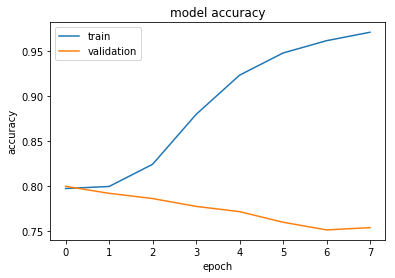

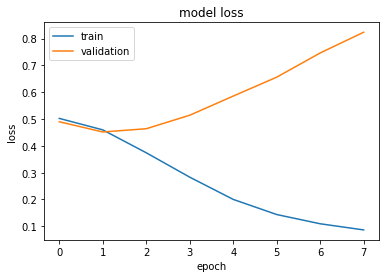

In [177]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import grid_search
import matplotlib.pyplot as plt

##After several trials, I had the best results with batch_size = 30 and n_epochs = 8

bs = 30
n_epochs = 8

history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev))

model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [195]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

y_pred = model.predict(X_test)

y_pred_final=[]
for i in range(y_pred.shape[0]):
    y_pred_final.append(np.argmax(y_pred[i]))

f = open('logreg_lstm_y_test_sst.txt', 'w')
    
for i in range(len(y_pred_final)):                  
    f.write(str(y_pred_final[i]))                  
f.close()  


## 4.3 -- innovate !

In [204]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping


#Building a new linear classifier
model_2 = Sequential()

#Adding Conv1D layer
model_2.add(Embedding(vocab_size, embed_dim))
model_2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))

#Adding LSTM layer
model_2.add(LSTM(nhid))
model_2.add(Dense(n_classes, activation='softmax'))

#Compile the model


model_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model_2.summary()
            
model_2.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=12)

model_2.evaluate(X_test, y_test)
            
y_pred = model.predict(X_test)

y_pred_final=[]
for i in range(y_pred.shape[0]):
    y_pred_final.append(np.argmax(y_pred[i]))

f = open('1DConv_lstm_y_test_sst.txt', 'w')
    
for i in range(len(y_pred_final)):                  
    f.write(str(y_pred_final[i]))                  
f.close() 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 48)          8872176   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          4640      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 325       
Total params: 8,901,973
Trainable params: 8,901,973
Non-trainable params: 0
_________________________________________________________________
Train on 8544 samples, validate on 1101 samples
Epoch 1/12
8544/8544 [==============================] - 49s 6ms/step - loss: 1.5435 